In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext memory_profiler
%matplotlib inline
from context import planvec

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from skimage import measure, segmentation

from planvec import img_proc
from planvec.common import PROJECT_ROOT_PATH

In [ ]:
ASSETS_DIR      = os.path.join(PROJECT_ROOT_PATH, 'test', 'assets')
INPUT_IMAGE     = 'gripper_foto.jpg'
INPUT_IMAGE     = 'scaled.jpg'
INPUT_IMAGE     = 'fileworks.jpeg'
OUTPUT_PDF_NAME = 'sample_output.pdf'

input_img = planvec.io.read_img(ASSETS_DIR, INPUT_IMAGE, to_bgr=True)
img = img_proc.copy_img(input_img)  # Perform processing on image copy to keep original input unaltered
#img = img_proc.add_gaussian_blur(img, 5, 5)
#img = img_proc.rectify_wrt_red_dots(img, (1200, 700), verbose=True, show_plot=True)

In [ ]:
planvec.io.scale_image(os.path.join(ASSETS_DIR, INPUT_IMAGE), os.path.join(ASSETS_DIR, 'scaled.jpg'), width=1200)

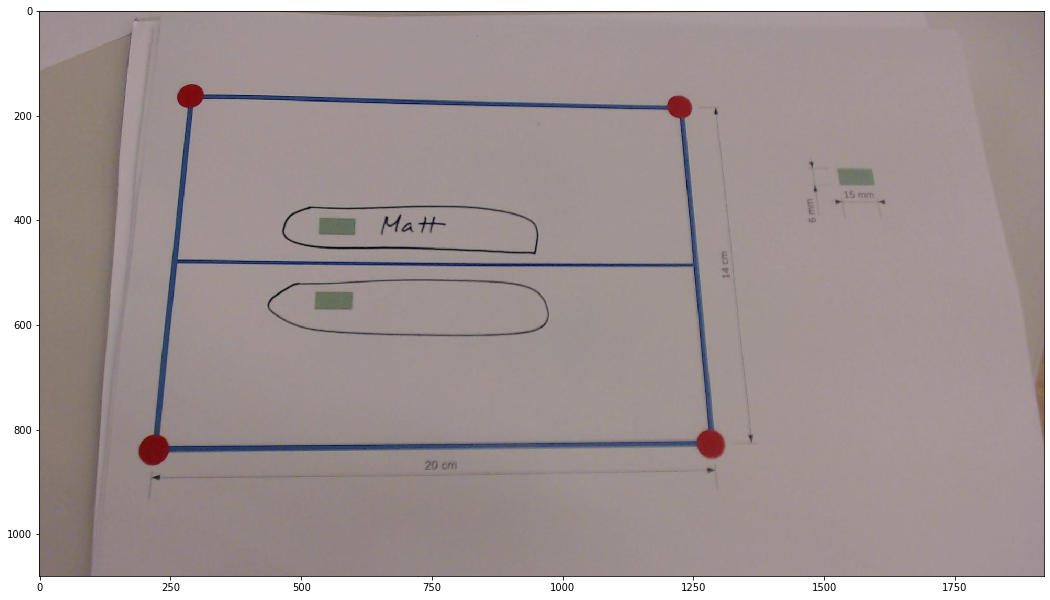

In [7]:
# Input image
#input_img = planvec.io.read_img(ASSETS_DIR, INPUT_IMAGE, to_bgr=True)
bunny_path = '/home/matt/code/planvec/data/2019-11-04/bunny/0_bunny_2019-11-04_15-38-51-743988_original.jpeg'
bunny_path = '/home/matt/code/planvec/data/2019-11-04/matt/0_matt_2019-11-04_17-20-35-882696_original.jpeg'
input_img = planvec.io.read_img_full_path(bunny_path, to_bgr=True)
planvec.vizualization.imshow(input_img, axis='on', figsize=(18,12), img_space='BGR')

In [ ]:
#planvec.vizualization.imshow(img, axis='on', figsize=(10, 10), img_space='BGR')
from config import CONFIG

img_blue = img_proc.filter_keep_by_hsv_range(input_img, CONFIG.color_range.blue)
planvec.vizualization.imshow(img_blue, axis='off', figsize=(10,10), img_space='BGR')

img_green = img_proc.filter_keep_by_hsv_range(input_img, CONFIG.color_range.green)
planvec.vizualization.imshow(img_green, axis='off', figsize=(10,10), img_space='BGR')

img_red = img_proc.filter_keep_multi_ranges(input_img, [CONFIG.color_range.red_low, CONFIG.color_range.red_high])
planvec.vizualization.imshow(img_red, axis='off', figsize=(10,10), img_space='BGR')
    
#img_clean = img_proc.filter_out_multi_ranges(input_img, [[50,59,0], [0,71,71], [170, 60, 60], [82,40,40]], [[70,255,255], [5,255,255], [180, 255, 255], [151,255,255]])
#planvec.vizualization.imshow(img_clean, axis='off', figsize=(10, 10), img_space='BGR')

In [ ]:
"""
step 0 
    - filter out helper lines:
    - bounding box of the whole thing
    - circle around connection points
    - middle line
    
step 1 - filter for red edges and get 4 coordinates
    - HSV color filter

step 2 - warp image such that edge points are new edges
    - cv perspective transform
    - filter out points

step 3 - do all the processing to find contours
    - ...

step 4 - put in connector holes in correct positions
    - place it by known position ratio w.r.t. edges
"""

In [ ]:
mask = img_proc.create_hsv_range_mask(img_proc.copy_img(input_img), CONFIG.color_range.blue)
planvec.vizualization.imshow(mask, axis='on', img_space='BGR', figsize=(18, 12))

In [ ]:
color_ranges = [color_range.BLUE, color_range.RED_HIGH, color_range.RED_LOW, color_range.GREEN]
img = planvec.img_proc.filter_multi_hsv_ranges_to_white(input_img, color_ranges)
planvec.vizualization.imshow(img, axis='on', img_space='BGR', figsize=(18, 12))
img = planvec.img_proc.img_to_greyscale(img)
img = img_proc.thresh_img(img, 100, 255)
planvec.vizualization.imshow(img, axis='on', img_space='BGR', figsize=(18, 12))

In [ ]:
img_thresh = img_proc.thresh_img(img, thresh_val=150, max_val=255, thresh_type=cv2.THRESH_BINARY)

In [ ]:
# Find and plots contours
#contours = img_proc.find_contours(img_thresh, 254)
#contours = img_proc.filter_contours_by_size(contours, n_points_thresh=1000)
#planvec.vizualization.plot_contours(contours, axis='on', figsize=(7, 10))

In [ ]:
# Labelling connected regions
labelled_img, n = measure.label(img_thresh, background=0, return_num=True)
regions = measure.regionprops(labelled_img)

In [ ]:
areas = []
for region in regions:
    areas.append(region.area)

In [ ]:
# Filtering regions
img_labelled_proc, filtered_regions = img_proc.filter_regions(labelled_img, regionprops=regions, area_threshold=100, verbose=True)

In [ ]:
planvec.vizualization.imshow(img_labelled_proc)

In [ ]:
planvec.vizualization.plot_image_regions(img_labelled_proc, filtered_regions)

In [ ]:
# Find contours of processed labelled image
contours = img_proc.find_contours(img_labelled_proc!=0, 0)
contours = img_proc.filter_contours_by_size(contours, n_points_thresh=100)
planvec.vizualization.plot_contours(contours, axis='off', figsize=(7, 10))
print(f'Contours left: {len(contours)}')

In [ ]:
# Smooth contours by polygon approximation
approx_contours = []
for contour in contours:
    approx_contours.append(skimage.measure.approximate_polygon(contour.copy(), tolerance=1))
output_fig = planvec.vizualization.plot_contours(approx_contours, axis='off', color='red', linewidth=0.9)

In [ ]:
output_fig.savefig('output_lw005.pdf')

In [ ]:
# Stores the processed image to a PDF in the assets directory
# Deprecated
# img_proc.img_to_pdf(os.path.join(ASSETS_DIR, OUTPUT_PDF_NAME), img_thresh)

In [ ]:
img_proc.live_color_filter(use_camera=False, img=img_proc.copy_img(input_img))

Input image shape: (1080, 1920, 3)
-----
Warping image wrt corners. Found 4 corners at positions
[[ 289.09  162.26]
 [ 219.6   838.65]
 [1283.25  827.29]
 [1223.53  183.2 ]]
Mapped to 
[[   0    0]
 [   0 1344]
 [1920 1344]
 [1920    0]].
New image size: (1920, 1344).
Found 49 regions.
Region 1 has area: 2191843 == (image size). Removed.
Region 3 has area: 1 < 5000. Too small. Removed.
Region 4 has area: 1 < 5000. Too small. Removed.
Region 5 has area: 13 < 5000. Too small. Removed.
Region 6 has area: 12 < 5000. Too small. Removed.
Region 7 has area: 1 < 5000. Too small. Removed.
Region 8 has area: 8 < 5000. Too small. Removed.
Region 9 has area: 3 < 5000. Too small. Removed.
Region 10 has area: 4 < 5000. Too small. Removed.
Region 11 has area: 9 < 5000. Too small. Removed.
Region 12 has area: 5 < 5000. Too small. Removed.
Region 13 has area: 25 < 5000. Too small. Removed.
Region 14 has area: 3 < 5000. Too small. Removed.
Region 16 has area: 1 < 5000. Too small. Removed.
Region 17 has 

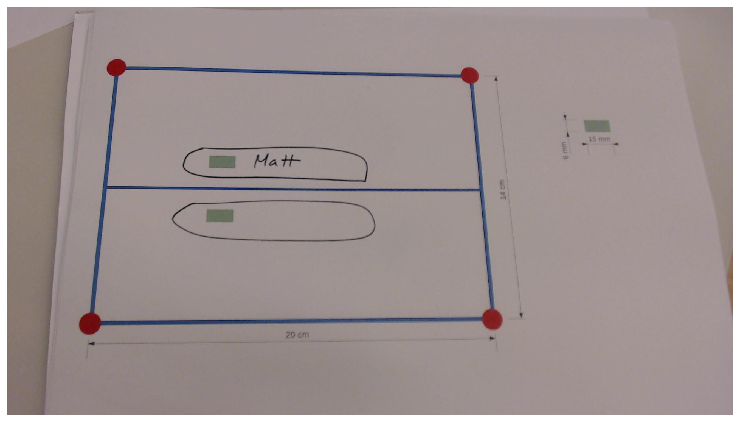

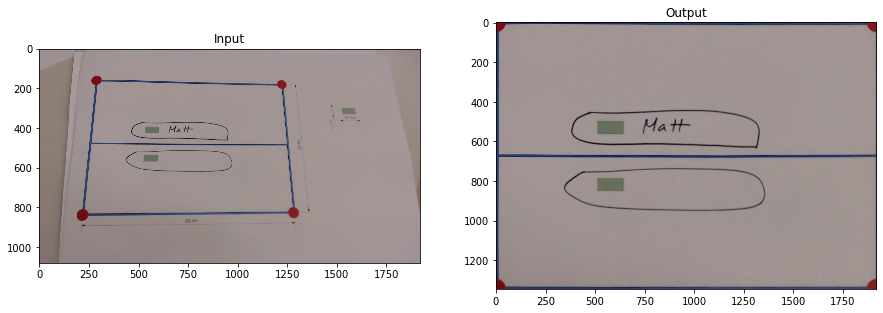

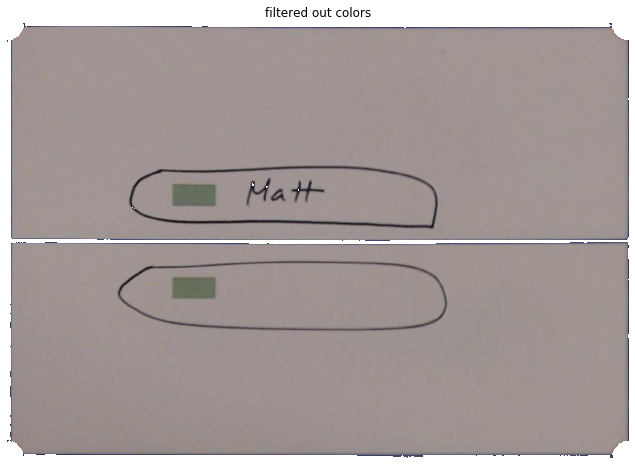

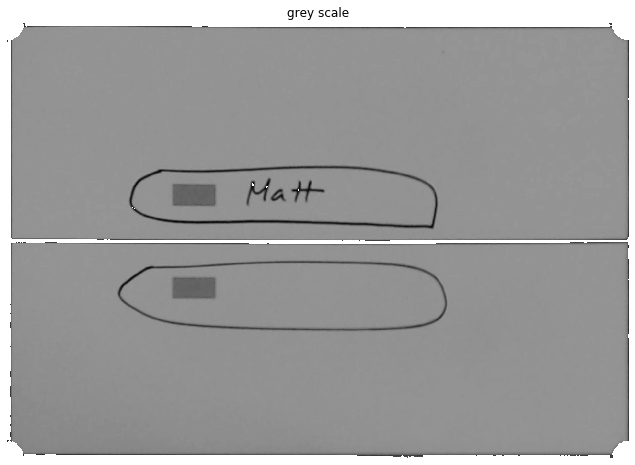

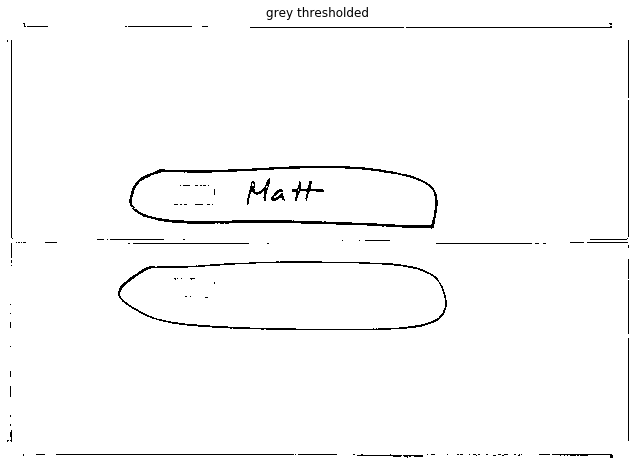

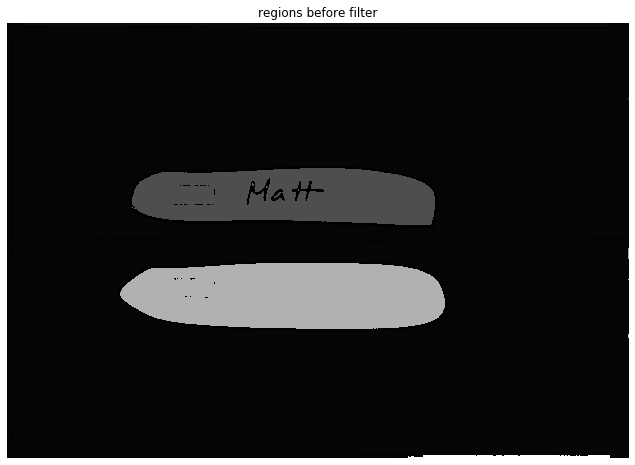

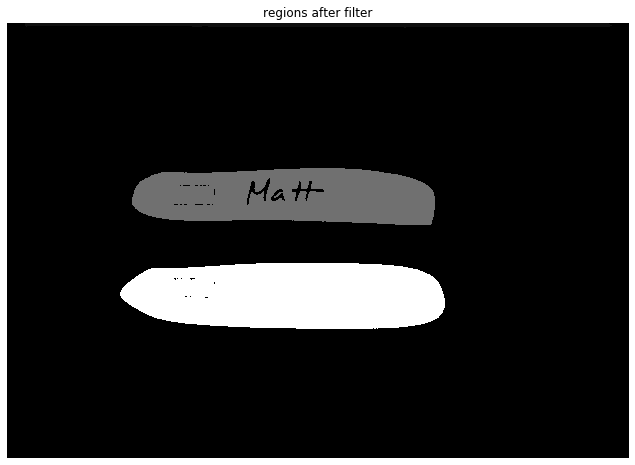

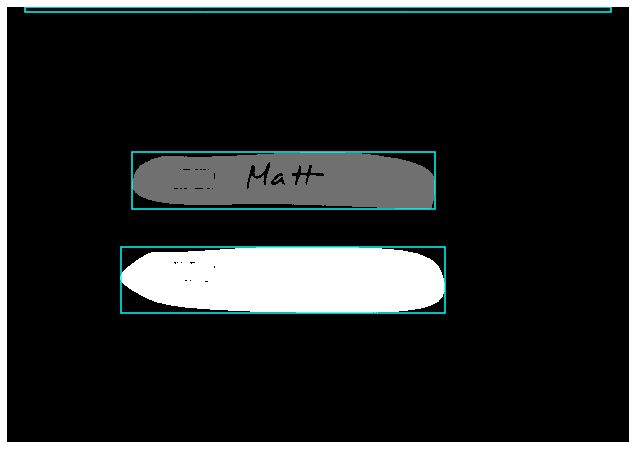

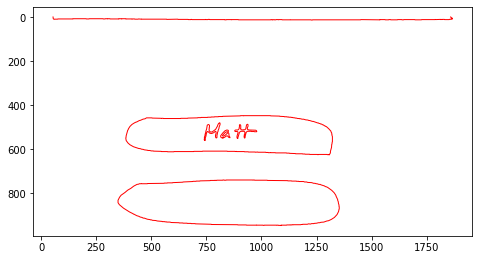

In [10]:
from planvec.pipeline import run_pipeline

output_img = run_pipeline(input_img, visualize_steps=True, verbose=True, return_fig=True)
plt.show()

In [ ]:
plt.imshow(output_img)

In [ ]:
###### from planvec.conversions import qtimg2rgb
plt.figure(figsize=(14, 10))
plt.imshow(qtimg2rgb(output_img))

In [9]:
from planvec.common import DATA_DIR_PATH
def save_output_fig(out_fig, path=os.path.join(DATA_DIR_PATH, 'tentakel2.pdf')):
    out_fig.savefig(path)
save_output_fig(output_img)

AttributeError: 'Image' object has no attribute 'savefig'

In [ ]:
print(plt.rcParams.get('figure.figsize'))

In [ ]:
import PyPDF2 as pypdf